# *(Vreeswijk & Sompolinsky, 1996)* E/I balanced network

## Overviews

Van Vreeswijk and Sompolinsky proposed E-I balanced network in 1996 to explain the temporally irregular spiking patterns. They suggested that the temporal variability may originated from the balance between excitatory and inhibitory inputs.

There are $N_E$ excitatory neurons and $N_I$ inbibitory neurons.

An important feature of the network is random and sparse connectivity. Connections between neurons $K$ meets $1 << K << N_E$. 

## Implementations

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [2]:
bp.__version__

'2.4.3'

Dynamic of membrane potential is given as:

$$ \tau \frac {dV_i}{dt} = -(V_i - V_{rest}) + I_i^{ext} + I_i^{net} (t) $$

where $I_i^{net}(t)$ represents the synaptic current, which describes the sum of excitatory and inhibitory neurons.

$$ I_i^{net} (t) = J_E \sum_{j=1}^{pN_e} \sum_{t_j^\alpha < t} f(t-t_j^\alpha ) - J_I \sum_{j=1}^{pN_i} \sum_{t_j^\alpha < t} f(t-t_j^\alpha )$$

where 

$$ f(t) = \begin{cases} {\rm exp} (-\frac t {\tau_s} ), \quad t \geq 0 \\
0, \quad t < 0 \end{cases} $$

Parameters: $J_E = \frac 1 {\sqrt {pN_e}}, J_I = \frac 1 {\sqrt {pN_i}}$

We can see from the dynamic that network is based on leaky Integrate-and-Fire neurons, and we can just use `get_LIF` from `bpmodels.neurons` to get this model. 

The function of $I_i^{net}(t)$ is actually a synase with single exponential decay, we can also get it by using `get_exponential`.

### Network

Let's create a neuron group with $N_E$ excitatory neurons and $N_I$ inbibitory neurons. Use `conn=bp.connect.FixedProb(p)` to implement the random and sparse connections.

In [3]:
class EINet(bp.DynSysGroup):
  def __init__(self, num_exc, num_inh, prob, JE, JI):
    # neurons
    pars = dict(V_rest=-52., V_th=-50., V_reset=-60., tau=10., tau_ref=0.,
                V_initializer=bp.init.Normal(-60., 10.))
    E = bp.neurons.LIF(num_exc, **pars)
    I = bp.neurons.LIF(num_inh, **pars)

    # synapses
    E2E = bp.synapses.Exponential(E, E, bp.conn.FixedProb(prob), g_max=JE, tau=2.)
    E2I = bp.synapses.Exponential(E, I, bp.conn.FixedProb(prob), g_max=JE, tau=2.)
    I2E = bp.synapses.Exponential(I, E, bp.conn.FixedProb(prob), g_max=JI, tau=2.)
    I2I = bp.synapses.Exponential(I, I, bp.conn.FixedProb(prob), g_max=JI, tau=2.)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [4]:
num_exc = 500
num_inh = 500
prob = 0.1

Ib = 3.
JE = 1 / bp.math.sqrt(prob * num_exc)
JI = -1 / bp.math.sqrt(prob * num_inh)

In [5]:
net = EINet(num_exc, num_inh, prob=prob, JE=JE, JI=JI)

runner = bp.DSRunner(net,
                     monitors=['E.spike'],
                     inputs=[('E.input', Ib), ('I.input', Ib)])
t = runner.run(1000.)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Visualization

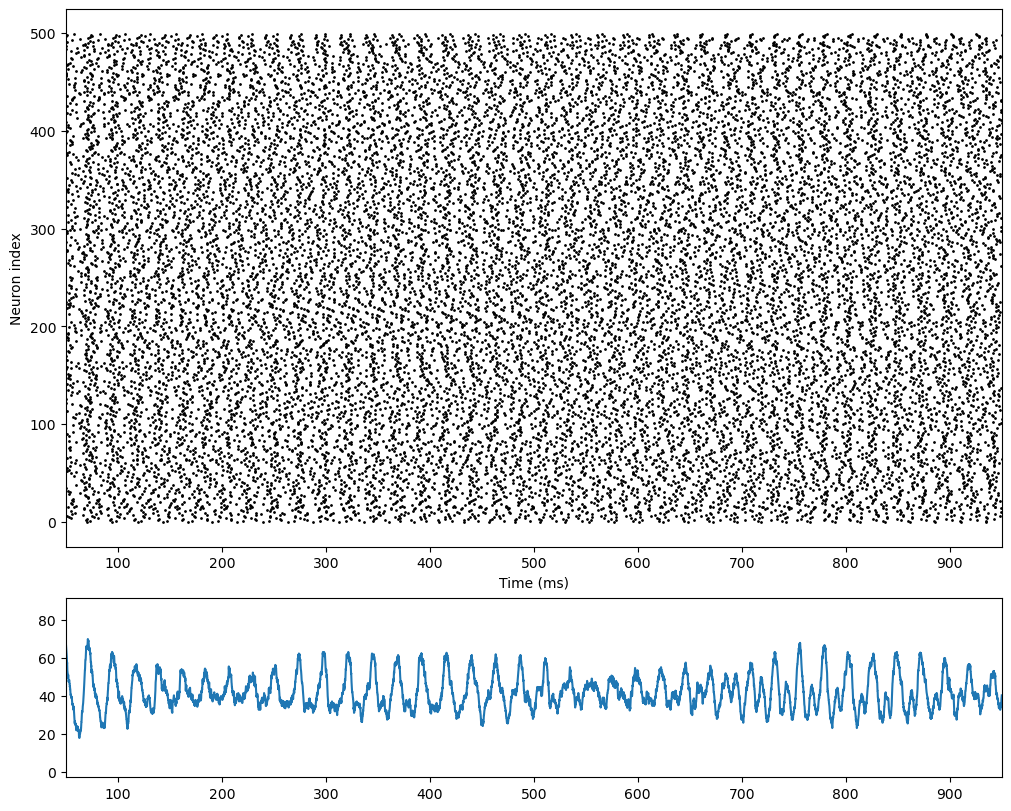

In [6]:
import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(4, 1, 2, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], xlim=(50, 950))

fig.add_subplot(gs[3, 0])
rates = bp.measure.firing_rate(runner.mon['E.spike'], 5.)
plt.plot(runner.mon.ts, rates)
plt.xlim(50, 950)
plt.show()

## Reference

[1] Van Vreeswijk, Carl, and Haim Sompolinsky. "Chaos in neuronal networks with balanced excitatory and inhibitory activity." Science 274.5293 (1996): 1724-1726.